In [14]:
from matplotlib.patches import Rectangle
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# pan-Antarctic integrated mass loss

In [15]:
def plot_total(ds,grd,case_str,plot=False):
    
    s2a = 365*24*3600
    ism = (grd.zice < 0.0)&(grd.mask_rho==1)
    ism.values[200:300,400:500] = False
    
    dA = (1.0/(grd.pm *grd.pn)).where(ism)
    weights = dA/dA.sum()
    
    m_avg = (ds.m.where(ism)*weights*s2a).sum(['eta_rho','xi_rho'])[:]
    
    if plot:
        plt.close()
        fig,ax1 = plt.subplots(1,figsize=(10,4))
        plt.suptitle('Area integrated melt rate evolution of case: '+case_str)
        m_avg.plot(ax=ax1)
        ax1.set_title('Absolute values in [m/s]')
        
        plt.show()
    
    return m_avg

In [9]:
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_grd.nc')
grd10 = xr.open_dataset(grid_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_M3','ocean_avg_00??.nc')
avg10 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
mavg10 = plot_total(avg10,grd10,'10km')

In [4]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_nt','ocean_avg_00??.nc')
avg10_nt = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100}).isel(ocean_time=range(15*12))
mavg10_nt = plot_total(avg10_nt,grd10,'10km')

In [16]:
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom4_grd.nc')
grd4 = xr.open_dataset(grid_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom4','ocean_avg_00??.nc')
avg4 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
mavg4 = plot_total(avg4,grd4,'4km')

In [12]:
file_path = os.path.join(os.environ.get('rawdir'),'waom4_nt','ocean_avg_00??.nc')
avg4_nt = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
mavg4_nt = plot_total(avg4_nt,grd4,'4km')

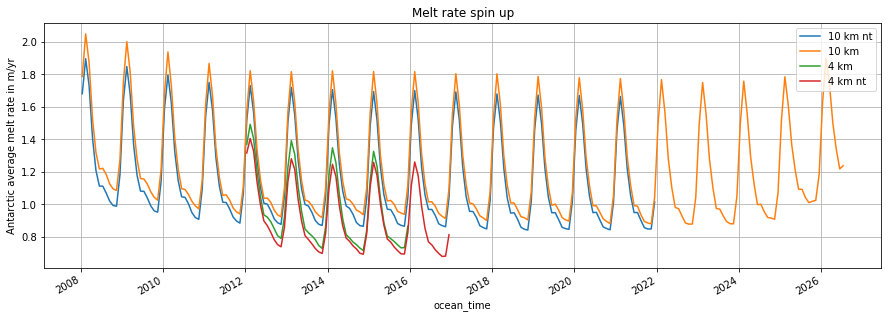

In [13]:
plt.close()
plt.figure(figsize=(15,5))
mavg10_nt[12:].plot(label='10 km nt')
mavg10[12:].plot(label='10 km')
mavg4.plot(label='4 km')
mavg4_nt.plot(label='4 km nt')
plt.title('Melt rate spin up')
plt.legend()
plt.grid('True')
plt.ylabel('Antarctic average melt rate in m/yr')
plt.show()

# Find lat/lon coordinates of major ice shelves
We do this to make the later analysis grid independent.
## Functions

In [9]:
#find and return lat/lon coordinates to specific eta/xi corner points
def xiEta2latLon(xi_ll,eta_ll,xi_ur,eta_ur,grd):
    sel = grd.sel(eta_rho=eta_ll,xi_rho=xi_ll)
    lat_ll = sel.lat_rho.values
    lon_ll = sel.lon_rho.values
    
    sel = grd.sel(eta_rho=eta_ur,xi_rho=xi_ur)
    lat_ur = sel.lat_rho.values
    lon_ur = sel.lon_rho.values
    
    return lat_ll,lon_ll,lat_ur,lon_ur

#for specific eta/xi corner points, plot a rectangle on map and return array with [name,[lat_ll,lon_ll,lat_ur,lon_ur]]
def find_shelf(grd,xi_ll,eta_ll,xi_ur,eta_ur,name):
    plt.close()
    fig,ax1=plt.subplots(1,figsize=(15,10))
    grd.zice.where(grd.mask_rho).where(grd.zice<0.0).plot(ax=ax1)
    ax1.add_patch(Rectangle((xi_ll,eta_ll), xi_ur-xi_ll, eta_ur-eta_ll, fill=False,color="r"))
    plt.grid(which='both')
    plt.show()
    
    return (name,xiEta2latLon(xi_ll,eta_ll,xi_ur,eta_ur,grd))

## Manually selecting ice shelves coordinates

In [10]:
%matplotlib inline
FRIS = find_shelf(grd10,275,380,377,480,'Flichner-Ronne IS')
RIS = find_shelf(grd10,365,225,475,330,'Ross IS')
AIS = find_shelf(grd,585,420,660,460,'Amery IS')
#PIIS = find_shelf(grd,255,330,280,350)
TMIS = find_shelf(grd,635,225,665,275,'Totten Moscow IS')
BHIS = find_shelf(grd,200,300,260,455,'Bellinghausen IS')

NameError: name 'grd' is not defined

# Plot area average melt rates based on lat/lon coordinates
## Functions

In [3]:
from scipy.spatial import KDTree
#find eta/xi values based on grid and lat/lon combo
def find_etaxi(lat,lon,grd):

    lat_flat = grd.lat_rho.stack(etaxi = ('eta_rho','xi_rho'))
    lon_flat = grd.lon_rho.stack(etaxi = ('eta_rho','xi_rho'))

    points = np.column_stack((lat_flat.values,lon_flat.values))
    tree = KDTree(points)

    target = np.column_stack((lat,lon))
    dist, ind = tree.query(target)

    eta = int(lat_flat[ind].eta_rho.values)
    xi = int(lat_flat[ind].xi_rho.values)

    return eta,xi

#calculate and plot area average melt rate over time based on grid, whole domain melt rate and corner coordinates in lat/lon
def plot_area_avg_m(grd,m,lat_ll,lon_ll,lat_ur,lon_ur,name):
    s2a = 365*24*3600
    print('Processing '+name+' ...')    
    eta_ll,xi_ll = find_etaxi(lat_ll,lon_ll,grd)
    eta_ur,xi_ur = find_etaxi(lat_ur,lon_ur,grd)
    
    grd_sel = grd.isel(xi_rho=slice(xi_ll,xi_ur),eta_rho=slice(eta_ll,eta_ur))
    m_sel = m.isel(xi_rho=slice(xi_ll,xi_ur),eta_rho=slice(eta_ll,eta_ur)).where((grd_sel.mask_rho==1) & (grd_sel.zice<0.0))
    m_sel = m_sel*s2a
    
    dA = (1.0/(grd_sel.pm *grd_sel.pn)).where((grd_sel.mask_rho==1) & (grd_sel.zice<0.0))
    weights = (dA/dA.sum())
    
    #m_avg = (m_sel*weights.values).sum(['eta_rho','xi_rho'])
    m_avg = (m_sel.values).sum(['eta_rho','xi_rho'])
    
    plt.close()
    grd_sel.zice.where(grd_sel.mask_rho).plot()
    plt.title('Ice draft of '+name)
    plt.show()
    ((m_avg[3:]-m_avg[3])/m_avg[3]*100).plot()    
    plt.title('Area average melt change to ini value '+name)
    plt.ylabel('melt rate chnage in %')
    plt.show()

## Plots of Ice shelves and melt rates

In [21]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_small','ocean_avg_spinUp_000?.nc')
print('Load files: ',file_path)
ds = xr.open_mfdataset(file_path,data_vars="minimal")
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grd = xr.open_dataset(grid_path)

Load files:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/waom10_v2.0_small/ocean_avg_spinUp_000?.nc


Processing Flichner-Ronne IS ...


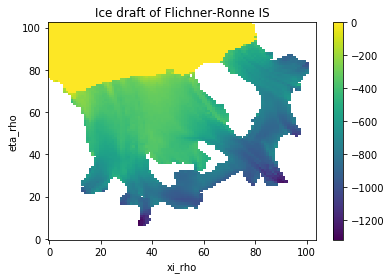

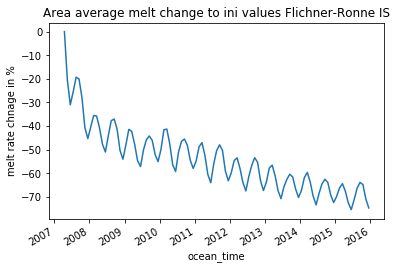

Processing Ross IS ...


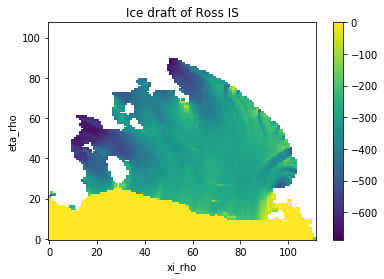

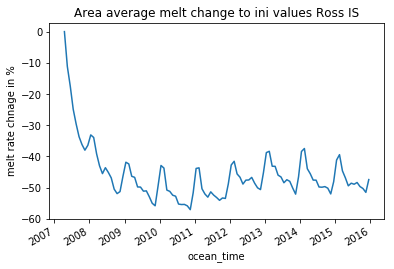

Processing Amery IS ...


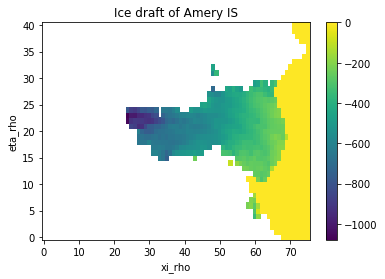

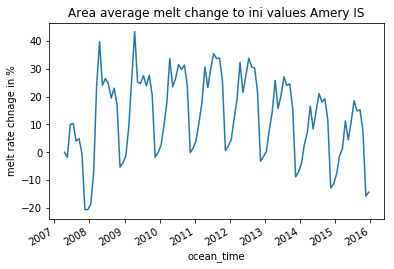

Processing Totten Moscow IS ...


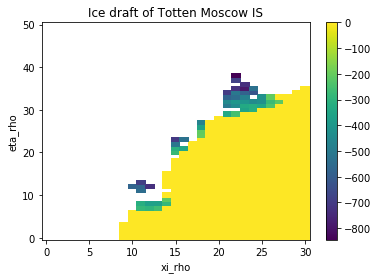

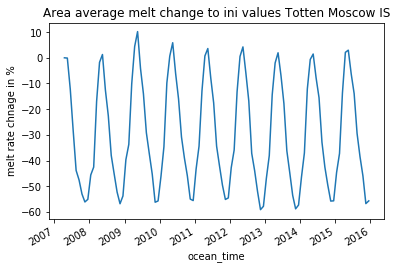

Processing Bellinghausen IS ...


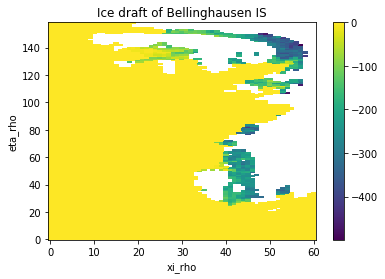

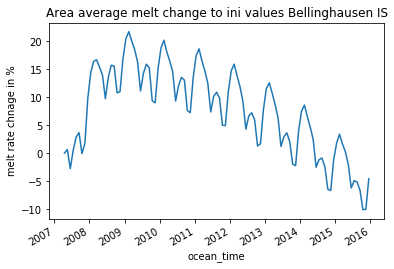

In [22]:
for IS in [FRIS,RIS,AIS,TMIS,BHIS]:
    plot_area_avg_m(grd,ds.m,IS[1][0],IS[1][1],IS[1][2],IS[1][3],IS[0])